In [193]:
import heapq
import numpy as np
import scipy.sparse
from sklearn import linear_model
import sys, os
import jax.numpy as jnp
import jax

from utils_mondrian import sample_cut, errors_regression

stable_sigmoid = lambda x: jnp.exp(jax.nn.log_sigmoid(x))

def evaluate_all_lifetimes(X, y, X_test, y_test, M, lifetime_max, delta,
                           validation=False):
    """
    Sweeps through Mondrian kernels with all lifetime in [0, lifetime_max]. This can be used to (1) construct a Mondrian
    feature map with lifetime lifetime_max, to (2) find a suitable lifetime (inverse kernel width), or to (3) compare
    Mondrian kernel to Mondrian forest across lifetimes.
    :param X:                       training inputs
    :param y:                       training regression targets
    :param X_test:                  test inputs
    :param y_test:                  test regression targets
    :param M:                       number of Mondrian trees
    :param lifetime_max:            terminal lifetime
    :param delta:                   ridge regression regularization hyperparameter
    :param validation:              flag indicating whether a validation set should be created by halving the test set
    :return: dictionary res containing all results
    """

    N, D = np.shape(X)
    N_test = np.shape(X_test)[0]
    X_all = np.array(np.r_[X, X_test])
    N_all = N + N_test
    
    y = np.squeeze(y)
    y_test = np.squeeze(y_test)

    # subtract target means
    y_mean = np.mean(y)
    y_train = y - y_mean

    # initialize sparse feature matrix
    indptr = range(0, M * N_all + 1, M)
    indices = list(range(M)) * N_all
    data = np.ones(N_all * M)
    Z_all = scipy.sparse.csr_matrix((data, indices, indptr), shape=(N_all, M))
    feature_from_repetition = list(range(M))
    C = M

    # bounding box for all datapoints used to sample first cut in each tree
    feature_data = [np.array(range(N_all)) for _ in range(M)]
    lX = np.min(X_all, 0)
    uX = np.max(X_all, 0)

    # event = tuple (time, tree, feature, dim, loc), where feature is the index of feature being split
    events = []
    active_features = []
    cuts = []
    feature_indices = []
    active_features_in_tree = [[] for _ in range(M)]
    for m in range(M):
        cut_time, dim, loc = sample_cut(lX, uX, 0.0)
        if cut_time < lifetime_max:
            heapq.heappush(events, (cut_time, m, m, dim, loc))
        active_features.append(m)
        active_features_in_tree[m].append(m)

    # iterate through birth times in increasing order
    list_times = []
    w_kernel = np.zeros(M)
    list_kernel_error_train = []
    if validation:
        list_kernel_error_validation = []
    list_kernel_error_test = []

    parent = {}

    while len(events) > 0:
        (birth_time, m, c, dim, loc) = heapq.heappop(events)
        list_times.append(birth_time)
        
        # construct new feature
        Xd = X_all[feature_data[c], dim]
        feature_l = (feature_data[c])[Xd <= loc]
        feature_r = (feature_data[c])[Xd  > loc]
        feature_data.append(feature_l)
        feature_data.append(feature_r)

        active_features.remove(c)
        active_features_in_tree[m].remove(c)
        active_features.append(C + 0)
        active_features.append(C + 1)
        active_features_in_tree[m].append(C + 0)
        active_features_in_tree[m].append(C + 1)
        feature_indices.append(dim)
        #feature_indices.append(dim)
        cuts.append([loc, 0])
        parent[C + 0] = c
        parent[C + 1] = c
        #cuts.append([loc, 1])

        # move datapoints from split feature to child features
        Z_all.indices[feature_l * M + m] = C + 0
        Z_all.indices[feature_r * M + m] = C + 1
        Z_all = scipy.sparse.csr_matrix((Z_all.data, Z_all.indices, Z_all.indptr), shape=(N_all, C + 2), copy=False)

        # sample the cut for each child
        lX_l = np.min(X_all[feature_l, :], axis=0)
        uX_l = np.max(X_all[feature_l, :], axis=0)
        cut_time_l, dim_l, loc_l = sample_cut(lX_l, uX_l, birth_time)
        lX_r = np.min(X_all[feature_r, :], axis=0)
        uX_r = np.max(X_all[feature_r, :], axis=0)
        cut_time_r, dim_r, loc_r = sample_cut(lX_r, uX_r, birth_time)

        # add new cuts to heap
        if cut_time_l < lifetime_max:
            heapq.heappush(events, (cut_time_l, m, C + 0, dim_l, loc_l))
        if cut_time_r < lifetime_max:
            heapq.heappush(events, (cut_time_r, m, C + 1, dim_r, loc_r))

        feature_from_repetition.append(m)
        feature_from_repetition.append(m)
        C += 2

        # update Mondrian kernel predictions
        w_kernel = np.append(w_kernel, [w_kernel[c], w_kernel[c]])
        w_kernel[c] = 0
        Z_train = Z_all[:N]
        Z_test = Z_all[N:]

        clf = linear_model.SGDRegressor(alpha=delta, fit_intercept=False)
        clf.fit(Z_train, y_train, coef_init=w_kernel)
        w_kernel = clf.coef_

        y_hat_train = y_mean + Z_train.dot(w_kernel)
        y_hat_test = y_mean + Z_test.dot(w_kernel)
        if validation:
            error_train, error_validation =\
                errors_regression(y, y_test[:(N_test/2)], y_hat_train, y_hat_test[:(N_test/2)])
            error_train, error_test =\
                errors_regression(y, y_test[(N_test/2):], y_hat_train, y_hat_test[(N_test/2):])
            list_kernel_error_validation.append(error_validation)
        else:
            error_train, error_test = errors_regression(y, y_test, y_hat_train, y_hat_test)
        list_kernel_error_train.append(error_train)
        list_kernel_error_test.append(error_test)


        sys.stdout.write("\rTime: %.2E / %.2E (C = %d, test error = %.3f)" % (birth_time, lifetime_max, C, error_test/100))
        sys.stdout.flush()
    
    sys.stdout.write("\n")

    cuts = np.array(cuts)
    
    path_map = np.zeros(shape=(C, M))
    for i in range(M, C):
        v = np.copy(path_map[:, parent[i]])
        v[i] = 1
        v = v[...,None]
        path_map = np.hstack((path_map, v))
    path_map = path_map[M:, M:]

    
    threshold = cuts[:, 0]

    feature_indices = np.array(feature_indices)
    
    
    def get_feature(X_all, Z_all, feature_indices, threshold):
        hidden_features = X_all[:, feature_indices]
        c = 1000.0
        right_indicator = stable_sigmoid(c * (hidden_features - threshold))
        left_indicator = 1.0 - right_indicator
        soft_indicator = jnp.ravel(jnp.array([left_indicator.flatten(),right_indicator.flatten()]),order="F").reshape(
            (len(X_all), len(feature_indices)*2)
        )
        print(soft_indicator)
        F_leaf = jnp.multiply(soft_indicator, Z_all)
        F_leaf = jnp.matmul(F_leaf, path_map)
        return F_leaf

    F_leaf = get_feature(X, Z_train[:, M:].todense(), feature_indices, threshold)
    clf = linear_model.SGDRegressor(alpha=delta, fit_intercept=False)
    clf.fit(F_leaf, y_train, coef_init=w_kernel[M:])
    w_kernel = clf.coef_
    
    
    def predict(x, Z_all, feature_indices, threshold, beta):
        hidden_features = x[feature_indices]
        c = 1000.0
        right_indicator = stable_sigmoid(c * (hidden_features - threshold))
        left_indicator = 1.0 - right_indicator
        soft_indicator = jnp.ravel(jnp.array([left_indicator,right_indicator]),order="F")
        F_leaf = jnp.multiply(soft_indicator, Z_all)
        F_leaf = jnp.matmul(F_leaf, path_map)
        return jnp.dot(F_leaf, beta)
    
    #print(X_all.shape)
    #print(Z_all[:, M:].todense().shape)
    #print(len(feature_indices))
    #print(threshold.shape)
    #print(w_kernel[M:].shape)
    
    fs = jax.jit(jax.vmap(predict, in_axes=(0, 0, None, None, None), out_axes=0))
    grad_fs = jax.jit(jax.vmap(jax.grad(predict, argnums=0), in_axes=(0, 0, None, None, None), out_axes=0))
    
    y_hat = y_mean + fs(X_all, Z_all[:, M:].todense(), feature_indices, threshold, w_kernel)
    y_hat_train = y_hat[:N]
    y_hat_test = y_hat[N:]
    error_train, error_test = errors_regression(y, y_test, y_hat_train, y_hat_test)
    print(error_test/100)

    grads = np.array(grad_fs(X_all, Z_all[:, M:].todense(), feature_indices, threshold, w_kernel))
    # this function returns a dictionary with all values of interest stored in it
    results = {'times': list_times, 'Z': Z_all, 'feature_from_repetition': np.array(feature_from_repetition)}
    results['kernel_train'] = list_kernel_error_train
    results['kernel_test'] = list_kernel_error_test
    if validation:
        results['kernel_validation'] = list_kernel_error_validation
    return grads

Time: 9.93E-03 / 1.00E-02 (C = 354, test error = 0.604)
[[0.0000000e+00 1.0000000e+00 1.0000000e+00 ... 5.2737118e-16
  0.0000000e+00 1.0000000e+00]
 [1.0000000e+00 0.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 3.1826643e-15]
 [1.0000000e+00 0.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 0.0000000e+00]
 ...
 [1.0000000e+00 0.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 0.0000000e+00]
 [0.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  0.0000000e+00 1.0000000e+00]
 [1.0000000e+00 0.0000000e+00 1.0000000e+00 ... 0.0000000e+00
  1.0000000e+00 0.0000000e+00]]
0.5940580076843067


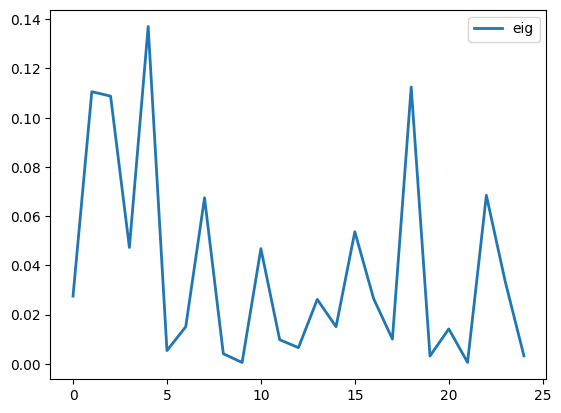

In [194]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import pandas as pd

def prepare_training_data(data, n_obs):
    df_train = data.head(n_obs)
    df_test = data.tail(40)

    x_train, y_train, f_train = df_train, df_train.pop("y"), df_train.pop("f")
    x_test, y_test, f_test = df_test, df_test.pop("y"), df_test.pop("f")


    x_train = x_train.to_numpy()
    #x_train = x_train[:,:10]
    x_test = x_test.to_numpy()
    #z_test = np.copy(x_test)
    #z_test[:, 1] = z_test[:, 1] + 1
    #x_test = np.vstack([x_test, z_test])
    
    #x_test = x_test[:,:10]

    y_train = y_train.to_numpy().reshape(-1, 1).ravel()
    y_test = y_test.to_numpy().reshape(-1, 1).ravel()
    #y_test = np.hstack([y_test, y_test])

    scaler = preprocessing.StandardScaler().fit(x_train)
    x_train = scaler.transform(x_train)
    x_test = scaler.transform(x_test)

    return x_train, y_train, x_test, y_test

if __name__ == "__main__":
    data_path = os.path.join("./datasets/")
    
    dataset_name = 'cont' # @param ['cat', 'cont', 'adult', 'heart', 'mi'] 
    outcome_type = 'linear' # @param ['linear', 'rbf', 'matern32', 'complex']
    n_obs = 1000 # @param [100, 200, 500, 1000]
    dim_in = 25 # @param [25, 50, 100, 200]
    rep = 1 # @param 

    data_file = f"{outcome_type}_n{n_obs}_d{dim_in}_i{rep}.csv"
    data_file_path = os.path.join(data_path, dataset_name, data_file)
    print(f"Data '{data_file}'", end='\t', flush=True)

    data = pd.read_csv(data_file_path, index_col=0)
    x_train, y_train, x_test, y_test = prepare_training_data(data, n_obs)


    M = 100                      # number of Mondrian trees to use
    lifetime_max = 0.01          # terminal lifetime
    weights_lifetime = 2*1e-6   # lifetime for which weights should be plotted
    delta = 0.01              # ridge regression delta
    grads = evaluate_all_lifetimes(x_train, y_train, x_test, y_test, M, lifetime_max, delta)
    
    import matplotlib.pyplot as plt

    x = np.linspace(0, dim_in-1, dim_in)

    fig, ax = plt.subplots()

    ax.plot(x, np.mean(np.abs(grads), axis=0), linewidth=2.0, label = "eig")

    plt.legend()
    plt.show()

In [195]:
x = np.random.rand(100)*2 - 1
def simulate_y(x):
    y = x[:, 0]**2 + x[:, 1]**2 + x[:, 2]**2 + x[:, 3]**2 + x[:, 4]**2
    return y

Time: 5.00E-02 / 5.00E-02 (C = 1750, test error = 0.187)
[[0.0000000e+00 1.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  1.0000000e+00 0.0000000e+00]
 [1.0000000e+00 0.0000000e+00 1.0000000e+00 ... 0.0000000e+00
  1.0000000e+00 0.0000000e+00]
 [0.0000000e+00 1.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  1.0000000e+00 0.0000000e+00]
 ...
 [1.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  1.0000000e+00 5.5305973e-09]
 [0.0000000e+00 1.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  1.0000000e+00 0.0000000e+00]
 [1.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  1.0000000e+00 0.0000000e+00]]
0.1862811371292903


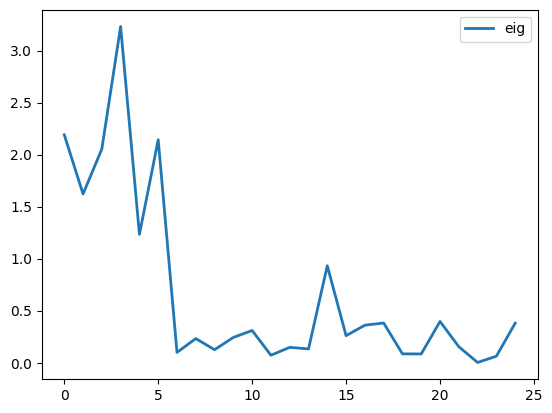

In [204]:
x = np.random.rand(1000,25)*2 - 1
y = simulate_y(x)
M = 100                      # number of Mondrian trees to use
lifetime_max = 0.05          # terminal lifetime
weights_lifetime = 2*1e-6   # lifetime for which weights should be plotted
delta = 0.1

grads = evaluate_all_lifetimes(x, y, x, y, M, lifetime_max, delta)

import matplotlib.pyplot as plt

x = np.linspace(0, dim_in-1, dim_in)

fig, ax = plt.subplots()

ax.plot(x, np.mean(grads**2, axis=0), linewidth=2.0, label = "eig")

plt.legend()
plt.show()